In [17]:
import pandas as pd


In [18]:
tourism_train = pd.read_csv("tourism_train_data.tsv",sep="\t")
tourism_train.head()

,Unnamed: 0,id,source_id,source,phrase,timestamp,user_id,validation_state,validation_score,domain,source_files,str_ranges
0,0,45325,20239,In a word - go!,Mwijambo - genda!,2023-05-15 10:10:42,42.0,1,3,tourism,trip_advisor,0-23
1,1,4991,3889,Can you recommend a good place for a single fe...,Ese wangir'inama ku hantu heza umugore w'ingar...,2023-04-27 15:36:45,NaN,0,1,tourism,paraphrased_lines,74-95
2,2,21875,12168,"Thank you Charles, Nelson and team of Gorilla ...","Murakoze Karori,Nelson n'itsinda ryo mu birunga",2023-05-11 07:51:30,128.0,1,3,tourism,trip_advisor,43-58
3,3,67886,27913,She is beautifully decorated.,Ni imitende itatse indinda.,2023-05-18 10:30:34,130.0,1,3,tourism,inyamibwa_historical_data,23-43
4,5,12178,8809,Not to talk about birds like African fish eagl...,Ntabwo ari ukuvuga gusa kunyoni nk'iza Afrika ...,2023-05-09 09:52:02,114.0,1,3,tourism,trip_advisor,195-max


In [19]:
# drop all other columns except source and phrase
tourism_train_og = tourism_train[["source","phrase"]]
tourism_train_og.head()

,source,phrase
0,In a word - go!,Mwijambo - genda!
1,Can you recommend a good place for a single fe...,Ese wangir'inama ku hantu heza umugore w'ingar...
2,"Thank you Charles, Nelson and team of Gorilla ...","Murakoze Karori,Nelson n'itsinda ryo mu birunga"
3,She is beautifully decorated.,Ni imitende itatse indinda.
4,Not to talk about birds like African fish eagl...,Ntabwo ari ukuvuga gusa kunyoni nk'iza Afrika ...


In [35]:
# minimise the dataset to allow less use of ram, use 10% of the dataset

tourism_train = tourism_train_og.sample(frac=0.3, random_state=42)
print(tourism_train.shape)

print(tourism_train_og.shape)

(7427, 2)
(24757, 2)


## Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with

In [36]:
# check the complexity of the vocabulary

# Combine all source and phrase texts into single strings
source_text = ' '.join(tourism_train['source'].tolist())
phrase_text = ' '.join(tourism_train['phrase'].tolist())

# Tokenize the texts and count unique tokens
source_vocab = set(source_text.split())
phrase_vocab = set(phrase_text.split())

print(f"Source Vocabulary Size: {len(source_vocab)}")
print(f"Phrase Vocabulary Size: {len(phrase_vocab)}")

# also let's analyze the frequency distribution of words to understand
# which words are most common and which are rare.
from collections import Counter

source_word_counts = Counter(source_text.split())
phrase_word_counts = Counter(phrase_text.split())

print("\nMost common English words:")
for word, count in source_word_counts.most_common(10):
  print(f"{word}: {count}")

print("\nMost common Kinyarwanda words:")
for word, count in phrase_word_counts.most_common(10):
  print(f"{word}: {count}")



Source Vocabulary Size: 15233
Phrase Vocabulary Size: 24179

Most common English words:
the: 5778
and: 4126
to: 3618
a: 2783
in: 2496
of: 2171
was: 1719
is: 1320
I: 1301
for: 1239

Most common Kinyarwanda words:
mu: 2327
kandi: 1614
muri: 1277
ku: 1092
na: 804
ya: 742
cyane: 739
ko: 670
yo: 537
urugendo: 533


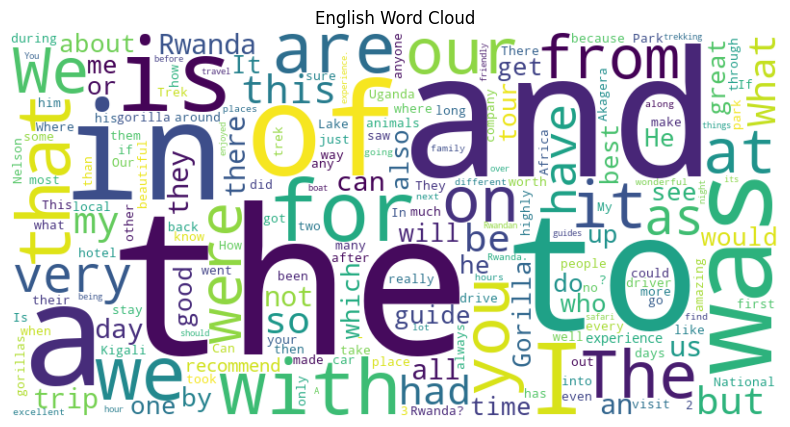

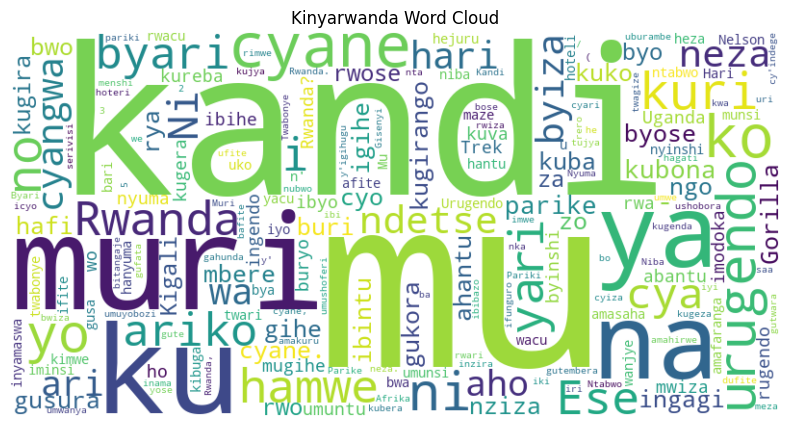

In [37]:
# prompt: create word clouds for bothe common words

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds
source_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(source_word_counts)
phrase_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(phrase_word_counts)

# Display the word clouds
plt.figure(figsize=(10, 5))
plt.imshow(source_wordcloud, interpolation='bilinear')
plt.title('English Word Cloud')
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(phrase_wordcloud, interpolation='bilinear')
plt.title('Kinyarwanda Word Cloud')
plt.axis("off")
plt.show()


In [38]:
# preprocess the data

import re

def preprocess_text(text):
  """
  Preprocesses text by:
    - Lowercasing
    - Removing punctuation
    - Removing extra whitespace
  """
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

# Apply preprocessing to source and phrase columns
tourism_train['source'] = tourism_train['source'].apply(preprocess_text)
tourism_train['phrase'] = tourism_train['phrase'].apply(preprocess_text)

tourism_train.head()


,source,phrase
6014,what is the best village to base in valais for...,nikihe cyaro cyiza cyo guturamo muri valais ha...
7602,do we have to prebook the airport lounge for o...,ese tugomba kwishyura mbere aho tuzaruhukira a...
4977,all in one a trip we will never forget,byose mu rugendo rumwe ntabwo tuzabyibagirwa
15095,i think if you get to the park by 800 you have...,ndatekereza ko ugeze muri parike 800 uzagira u...
12033,instead we walked for 20 mins across a farm an...,ahubwo twagenze iminota 20 hakurya mwishyamba ...


In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer for source language (tourism_train['source'])
source_tokenizer = Tokenizer()
source_tokenizer.fit_on_texts(tourism_train['source'])
source_sequences = source_tokenizer.texts_to_sequences(tourism_train['source'])

# Tokenizer for target language (tourism_train['phrase'])
phrase_tokenizer = Tokenizer()
phrase_tokenizer.fit_on_texts(tourism_train['phrase'])
phrase_sequences = phrase_tokenizer.texts_to_sequences(tourism_train['phrase'])

# Get the vocabulary size for source and target languages
vocab_size_src = len(source_tokenizer.word_index) + 1  # Adding 1 for padding token
vocab_size_trg = len(phrase_tokenizer.word_index) + 1  # Adding 1 for padding token


In [40]:
import numpy as np

# Set maximum length for the source and target sequences
max_source_length = max([len(seq) for seq in source_sequences])
max_phrase_length = max([len(seq) for seq in phrase_sequences])

# Pad the sequences (post-padding with zeros)
encoder_input_data = pad_sequences(source_sequences, maxlen=max_source_length, padding='post')
decoder_input_data = pad_sequences(phrase_sequences, maxlen=max_phrase_length, padding='post')

# Shift the target data to the right by 1 timestep
decoder_target_data = np.roll(decoder_input_data, -1, axis=1)
decoder_target_data[:, -1] = 0  # Ensure padding in the last position


In [41]:
from sklearn.model_selection import train_test_split

# Split the data
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_target_train, decoder_target_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42
)

# Print the shapes to check
print("Encoder Input Train Shape:", encoder_input_train.shape)
print("Decoder Input Train Shape:", decoder_input_train.shape)
print("Decoder Target Train Shape:", decoder_target_train.shape)


Encoder Input Train Shape: (5941, 112)
Decoder Input Train Shape: (5941, 74)
Decoder Target Train Shape: (5941, 74)


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# Define model parameters
embedding_dim = 256  # You can adjust this as needed
hidden_units = 256   # You can adjust this as well

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size_src, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_trg, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_trg, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, None, 256) │  2,405,632 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 256) │  4,521,472 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 256),     │    525,312 │ embedding_10[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, None,     │    525,312 │ embedding_11[0][… │
│                     │ 256), (None,      │            │ lstm_10[0][1],    │
│                     │ 256), (None,      │            │ lstm_10[0][2]     │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None,      │  4,539,134 │ lstm_11[0][0]     │
│                     │ 17662)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,516,862 (47.75 MB)

 Trainable params: 12,516,862 (47.75 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
history = model.fit(
    [encoder_input_train, decoder_input_train], 
    decoder_target_train, 
    batch_size=250, 
    epochs=5, 
    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val)
)


Epoch 1/5


/Users/macbook2015/ml1/Kinyarwanda_English_Translator/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_55', 'keras_tensor_60']. Received: the structure of inputs=('*', '*')
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1359s 55s/step - accuracy: 0.7146 - loss: 7.3566 - val_accuracy: 0.8434 - val_loss: 1.6459
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1381s 58s/step - accuracy: 0.8440 - loss: 1.6284 - val_accuracy: 0.8434 - val_loss: 1.4336
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2624s 112s/step - accuracy: 0.8454 - loss: 1.3399 - val_accuracy: 0.8434 - val_loss: 1.3295
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1703s 72s/step - accuracy: 0.8434 - loss: 1.2947 - val_accuracy: 0.8434 - val_loss: 1.3145
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2044s 87s/step - accuracy: 0.8448 - loss: 1.2672 - val_accuracy: 0.8434 - val_loss: 1.3114
